Since production data is annual, **start out** by making annual predictions

Also, see what happens when including pre-quota data (with ending stocks)

In [1]:
from capstone_modules import Production_Data, Temperature_Data, ICO_Composite_Indicator

import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
#from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Import data

In [2]:
master_dataframe = pd.DataFrame()

# Import production data
production = Production_Data()
ICO_categories = production.ICO_categories
for category in ICO_categories:
    temp_df = production.get_aggregate_production_data_by_ICO_category(category)
    temp_df.name = category + " Production (60 kg bags)"
    master_dataframe = pd.concat([master_dataframe, temp_df[temp_df.index > 1960]], axis = 1)

# Import ICO composite indicator index data
# ICO_composite_indicator = ICO_Composite_Indicator_Index()
ICO_composite_indicator = pd.read_csv("../datasets/capstone/ICO composite indicator index since 1960.csv")
ICO_composite_indicator = ICO_composite_indicator.set_index("Unnamed: 0")
ICO_composite_indicator.columns = ["ICO Composite Indicator (US cents/lb)"]
del ICO_composite_indicator.index.name
    
master_dataframe.index = pd.to_datetime(master_dataframe.index, format = "%Y").values
master_dataframe = ICO_composite_indicator.merge(master_dataframe, left_index = True, right_index = True)

In [3]:
master_dataframe.head()

,ICO Composite Indicator (US cents/lb),Brazilian Naturals Production (60 kg bags),Colombian Milds Production (60 kg bags),Other Milds Production (60 kg bags),Robustas Production (60 kg bags)
1961-01-01,29.79,31533000.0,7826000.0,12232000.0,8809000.0
1962-01-01,28.45,41657000.0,8096000.0,13561000.0,9181000.0
1963-01-01,30.26,31082000.0,7815000.0,13639000.0,10016000.0
1964-01-01,42.18,25530000.0,8280000.0,14272000.0,10726000.0
1965-01-01,37.08,13522000.0,9158000.0,14761000.0,9792000.0


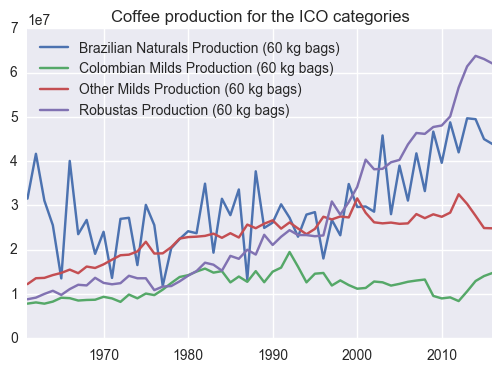

In [4]:
master_dataframe.drop("ICO Composite Indicator (US cents/lb)", axis = 1).plot()
plt.title("Coffee production for the ICO categories")
plt.show()

### Try predicting ICO composite indicator values from previous year's production values

In [5]:
def simple_linear_model(dataframe, show_actual_vs_predicted = False):
    X = dataframe.drop("ICO Composite Indicator (US cents/lb)", axis = 1).iloc[0:-1]
    y = dataframe["ICO Composite Indicator (US cents/lb)"].iloc[1:]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y)
    
    linear_model = LinearRegression()
    linear_model.fit(train_X, train_y)
        
    train_y.plot()
    plt.scatter(x = test_y.index, y = linear_model.predict(test_X), c ="r")
    plt.title("Linear Regression Model")
    plt.show()

    print("Linear model score: {}".format(linear_model.score(X, y)))
    print("Average cross validation score (MSE): {}".format(- cross_val_score(linear_model, X, y).mean()))

    if show_actual_vs_predicted == True:
        plt.scatter(linear_model.predict(test_X), test_y)
        plt.xlabel("Predicted ICO composite indicator values")
        plt.ylabel("Actual ICO composite indicator values")
        plt.title("Modeling ICO composite indicator from categories")
        plt.show()   
        
def random_forest_model(dataframe, show_actual_vs_predicted = False):
    X = dataframe.drop("ICO Composite Indicator (US cents/lb)", axis = 1).iloc[0:-1]
    y = dataframe["ICO Composite Indicator (US cents/lb)"].iloc[1:]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y)

    random_forest_reg = RandomForestRegressor()
    random_forest_reg.fit(train_X, train_y)

    train_y.plot()
    plt.scatter(x = test_y.index, y = random_forest_reg.predict(test_X), c ="r")
    plt.title("Random Forest Model")
    plt.show()
    
    print("Random forest model score: {}".format(random_forest_reg.score(X, y)))
    print("Average cross validation score (MSE): {}".format(- cross_val_score(random_forest_reg, X, y).mean()))

    if show_actual_vs_predicted == True:
        plt.scatter(random_forest_reg.predict(test_X), test_y)
        plt.xlabel("Predicted ICO composite indicator values")
        plt.ylabel("Actual ICO composite indicator values")
        plt.title("Modeling ICO composite indicator from categories")
        plt.show()   


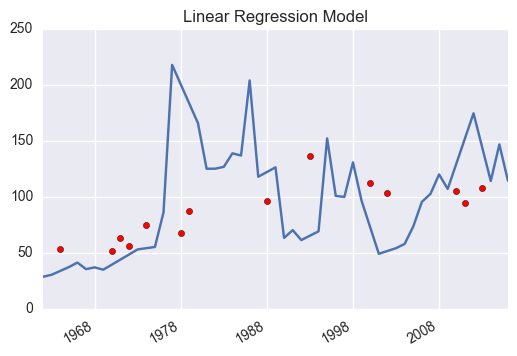

Linear model score: 0.1490181404350791
Average cross validation score (MSE): 9.05604615552153


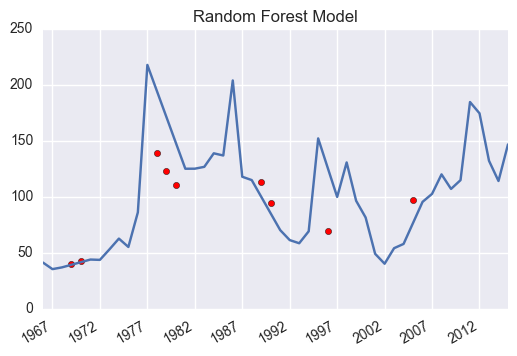

Random forest model score: 0.7936392012780022
Average cross validation score (MSE): 1.2706505287755359


In [6]:
simple_linear_model(master_dataframe)
random_forest_model(master_dataframe)

## Examine frost before harvest

* 9 months for Arabica 
* 10-11 months for Robusta

## Add ending stocks to master dataframe

In [7]:
brazilian_naturals_ending_stock = production.get_ending_stocks_by_ICO_category()
for country in brazilian_naturals_ending_stock["Country"].unique():
    brazilian_naturals_ending_stock.ix[brazilian_naturals_ending_stock["Country"] == country, "Percent Change"] = brazilian_naturals_ending_stock[brazilian_naturals_ending_stock["Country"] == country]["Value (60kg bags)"].pct_change()

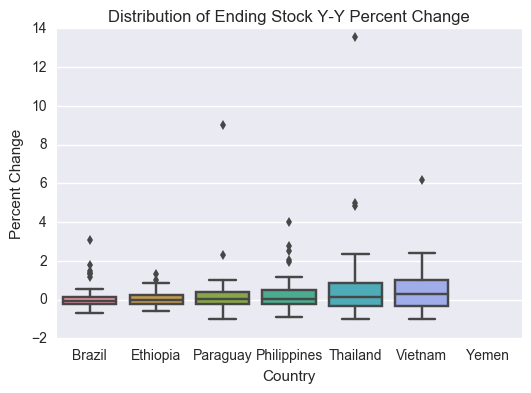

In [8]:
sns.boxplot(data = brazilian_naturals_ending_stock, x = "Country", y = "Percent Change")
plt.title("Distribution of Ending Stock Y-Y Percent Change")
plt.show()